In [33]:
import pandas as pd
import matplotlib
from sklearn import preprocessing
import numpy as np
import numpy
import random
import pickle
import matplotlib.pyplot
%matplotlib inline

In [34]:
df = pd.read_csv('dataset.csv')

/home/adil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
def bucketize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def bucketize_df(df):
    df['ydstogo'] = [bucketize(x, 4, 5) for x in df['ydstogo']]
    return df

def get_success(arguments):
    t, f1, f2, f3 = arguments
    if(t == 1.0 or f1 == 1.0 or f2 == 1.0 or f3 == 1.0):
        return 1
    else:
        return 0

data = df[(df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]
data =  data[['posteam', 'defteam', 'game_half', 'half_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'play_type', 'pass_location', 'run_location', 'pass_length', 'touchdown', 'first_down_rush', 'first_down_penalty', 'first_down_pass']]
data = data.replace(np.nan, 'unknown', regex=True)
data["success"] = data[['touchdown', 'first_down_rush', 'first_down_penalty', 'first_down_pass']].apply(get_success, axis=1)
data =  data[['posteam', 'defteam', 'game_half', 'half_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'play_type', 'pass_location', 'run_location', 'pass_length', 'success']]
data = bucketize_df(data)
#one hot encoding
data = pd.get_dummies(data, columns=['ydstogo','posteam', 'defteam', 'game_half', 'down', 'play_type', 'pass_location', 'run_location', 'pass_length'])
data = data[data['half_seconds_remaining'] != 'unknown']
#standardizing
data['yardline_100']/=100
data['half_seconds_remaining'] /= 1800

In [43]:
data = data[:10000]

In [44]:
data_o = data["success"]
data_i = data
del data_i["success"]
data_inputs = data_i.to_numpy()
data_inputs = data_inputs.astype('float64')
data_outputs = data_o.to_numpy()
data_outputs = data_outputs.astype('float64')

In [45]:
data_inputs.shape

(10000, 98)

In [46]:
## NEURAL NETWORK FUNCTIONS
def sigmoid(inpt):
    return 1.0/(1.0+numpy.exp(-1*inpt))

def relu(inpt):
    result = inpt
    result[inpt<0] = 0
    return result

def predict_outputs(weights_mat, data_inputs, data_outputs, activation="relu"):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = numpy.matmul(r1, curr_weights)
            if activation == "relu":
                r1 = relu(r1)
            elif activation == "sigmoid":
                r1 = sigmoid(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions/data_outputs.size)*100
    return accuracy, predictions
    
def fitness_func(weights_mat, data_inputs, data_outputs, activation="relu"):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inputs, data_outputs, activation=activation)
    return accuracy


In [47]:
## GENETIC ALGORITHM FUNCTIONS

# Converting each solution from matrix to vector.
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = numpy.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return numpy.array(pop_weights_vector)

# Converting each solution from vector to matrix.
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = numpy.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return numpy.reshape(mat_weights, newshape=mat_pop_weights.shape)

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_percent):
    num_mutations = numpy.uint32((mutation_percent*offspring_crossover.shape[1])/100)
    mutation_indices = numpy.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    return offspring_crossover


Generation :  0
Fitness
[28.82 28.82 71.18 28.82 71.18 28.82 71.18 28.82]
Parents
[[ 0.07177619 -0.05457971  0.09593989 ...  0.04004498 -0.0168077
  -0.09300528]
 [ 0.06768961 -0.04983687  0.07336127 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.05968638  0.02669948 -0.0372055  ...  0.08880474 -0.05055214
  -0.03609687]
 [-0.02886609 -0.09695414 -0.08274158 ... -0.05072091 -0.01085256
   0.0437831 ]]
Crossover
[[ 0.07177619 -0.05457971  0.09593989 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ... -0.05072091 -0.01085256
   0.0437831 ]
 [-0.02886609 -0.09695414 -0.08274158 ...  0.04004498 -0.0168077
  -0.09300528]]
Mutation
[[ 0.07177619 -0.05457971  0.09593989 ... -0.37977133 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ... -0.53343507 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ...  0.60405526 -0.01085256
   0.0437831 ]
 [-0.028

Fitness
[71.18 71.18 71.18 71.18 71.18 28.82 71.18 71.18]
Parents
[[ 0.07177619 -0.05457971  0.09593989 ...  0.04004498 -0.0168077
  -0.09300528]
 [ 0.06768961 -0.04983687  0.07336127 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.05968638  0.02669948 -0.0372055  ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.07177619 -0.05457971  0.09593989 ... -0.37977133 -0.01526401
  -0.0036364 ]]
Crossover
[[ 0.07177619 -0.05457971  0.09593989 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ... -0.37977133 -0.01526401
  -0.0036364 ]
 [ 0.07177619 -0.05457971  0.09593989 ...  0.04004498 -0.0168077
  -0.09300528]]
Mutation
[[ 0.07177619 -0.05457971  0.09593989 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ... -0.37977133 -0.01526401
  -0.0036364 ]
 [ 0.07177619 -0.0545797

Fitness
[71.18 71.18 71.18 71.18 28.82 71.18 28.82 71.18]
Parents
[[ 0.07177619 -0.05457971  0.09593989 ...  0.04004498 -0.0168077
  -0.09300528]
 [ 0.06768961 -0.04983687  0.07336127 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.05968638  0.02669948 -0.0372055  ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.07177619 -0.05457971  0.09593989 ... -0.37977133 -0.01526401
  -0.0036364 ]]
Crossover
[[ 0.07177619 -0.05457971  0.09593989 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ... -0.37977133 -0.01526401
  -0.0036364 ]
 [ 0.07177619 -0.05457971  0.09593989 ...  0.04004498 -0.0168077
  -0.09300528]]
Mutation
[[ 0.07177619 -0.05457971  0.09593989 ... -0.01445607 -0.01526401
  -0.0036364 ]
 [ 0.06768961 -0.04983687  0.07336127 ...  0.08880474 -0.05055214
  -0.03609687]
 [ 0.05968638  0.02669948 -0.0372055  ... -0.37977133 -0.01526401
  -0.0036364 ]
 [ 0.07177619 -0.0545797

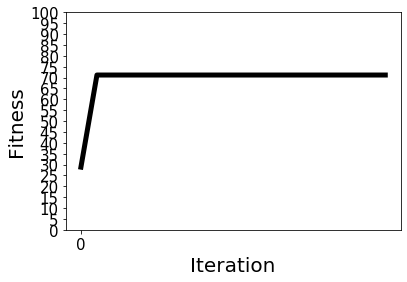

In [48]:

"""
Genetic algorithm parameters:
    Mating Pool Size (Number of Parents)
    Population Size
    Number of Generations
    Mutation Percent
"""

sol_per_pop = 8
num_parents_mating = 4
num_generations = 20
mutation_percent = 10

#Creating the initial population.
initial_pop_weights = []
for curr_sol in numpy.arange(0, sol_per_pop):
    HL1_neurons = 75
    input_HL1_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(data_inputs.shape[1], HL1_neurons))
    HL2_neurons = 30
    HL1_HL2_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(HL1_neurons, HL2_neurons))
    output_neurons = 2
    HL2_output_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                              size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(numpy.array([input_HL1_weights, 
                                                HL1_HL2_weights, 
                                                HL2_output_weights]))

pop_weights_mat = numpy.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = numpy.empty(shape=(num_generations))

for generation in range(num_generations):
    print("Generation : ", generation)

    # converting the solutions from being vectors to matrices.
    pop_weights_mat = vector_to_mat(pop_weights_vector, 
                                       pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    fitness = fitness_func(pop_weights_mat, 
                          data_inputs, 
                          data_outputs, 
                          activation="sigmoid")
    accuracies[generation] = fitness[0]
    print("Fitness")
    print(fitness)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(pop_weights_vector, 
                                    fitness.copy(), 
                                    num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, 
                                     mutation_percent=mutation_percent)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
print("Accuracy of the best solution is : ", acc)

matplotlib.pyplot.plot(accuracies, linewidth=5, color="black")
matplotlib.pyplot.xlabel("Iteration", fontsize=20)
matplotlib.pyplot.ylabel("Fitness", fontsize=20)
matplotlib.pyplot.xticks(numpy.arange(0, num_generations+1, 100), fontsize=15)
matplotlib.pyplot.yticks(numpy.arange(0, 101, 5), fontsize=15)
matplotlib.pyplot.show()

f = open("weights_"+str(num_generations)+"_iterations_"+str(mutation_percent)+"%_mutation.pkl", "wb")
pickle.dump(pop_weights_mat, f)
f.close()